# Demonstrating Artifacts in a Semantic Segmentation Model

We use a DeepLab V3 model pre-trained on CityScapes, available at https://github.com/VainF/DeepLabV3Plus-Pytorch

## Loading the Model (all layers use zero padding)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt


In [2]:
checkpoint = torch.load("/work/data/cityscapes/models/best_deeplabv3plus_mobilenet_cityscapes_os16.pth", map_location=torch.device('cpu'))



In [3]:
from collections import namedtuple
CityscapesClass = namedtuple('CityscapesClass', ['name', 'id', 'train_id', 'category', 'category_id',
                                                 'has_instances', 'ignore_in_eval', 'color'])
classes = [
    CityscapesClass('unlabeled',            0, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('ego vehicle',          1, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('out of roi',           3, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('static',               4, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('dynamic',              5, 255, 'void', 0, False, True, (111, 74, 0)),
    CityscapesClass('ground',               6, 255, 'void', 0, False, True, (81, 0, 81)),
    CityscapesClass('road',                 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    CityscapesClass('sidewalk',             8, 1, 'flat', 1, False, False, (244, 35, 232)),
    CityscapesClass('parking',              9, 255, 'flat', 1, False, True, (250, 170, 160)),
    CityscapesClass('rail track',           10, 255, 'flat', 1, False, True, (230, 150, 140)),
    CityscapesClass('building',             11, 2, 'construction', 2, False, False, (70, 70, 70)),
    CityscapesClass('wall',                 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    CityscapesClass('fence',                13, 4, 'construction', 2, False, False, (190, 153, 153)),
    CityscapesClass('guard rail',           14, 255, 'construction', 2, False, True, (180, 165, 180)),
    CityscapesClass('bridge',               15, 255, 'construction', 2, False, True, (150, 100, 100)),
    CityscapesClass('tunnel',               16, 255, 'construction', 2, False, True, (150, 120, 90)),
    CityscapesClass('pole',                 17, 5, 'object', 3, False, False, (153, 153, 153)),
    CityscapesClass('polegroup',            18, 255, 'object', 3, False, True, (153, 153, 153)),
    CityscapesClass('traffic light',        19, 6, 'object', 3, False, False, (250, 170, 30)),
    CityscapesClass('traffic sign',         20, 7, 'object', 3, False, False, (220, 220, 0)),
    CityscapesClass('vegetation',           21, 8, 'nature', 4, False, False, (107, 142, 35)),
    CityscapesClass('terrain',              22, 9, 'nature', 4, False, False, (152, 251, 152)),
    CityscapesClass('sky',                  23, 10, 'sky', 5, False, False, (70, 130, 180)),
    CityscapesClass('person',               24, 11, 'human', 6, True, False, (220, 20, 60)),
    CityscapesClass('rider',                25, 12, 'human', 6, True, False, (255, 0, 0)),
    CityscapesClass('car',                  26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    CityscapesClass('truck',                27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    CityscapesClass('bus',                  28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    CityscapesClass('caravan',              29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    CityscapesClass('trailer',              30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    CityscapesClass('train',                31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    CityscapesClass('motorcycle',           32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    CityscapesClass('bicycle',              33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    CityscapesClass('license plate',        -1, 255, 'vehicle', 7, False, True, (0, 0, 142)),
]


In [4]:
ind_to_label = {}
for c in classes:
    ind_to_label[c.train_id] = c.name

In [29]:
from DeepLabV3Plus import network
model = network.deeplabv3plus_mobilenet(num_classes=19, output_stride=16) # output_stride = 8

In [30]:
model.load_state_dict(checkpoint["model_state"])
model.to(torch.device('cpu'))
model.eval()
print("modal loaded")

modal loaded


In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'



In [31]:
activations = {}
def save_activation(name):
    def hook(mod, inp, out):
            activations[name] = out.detach().numpy()
    return hook

ind = 0
for mod in model.backbone.low_level_features:
    key = "lo_lvl_{}".format(ind)
    activations[key] = []
    mod.register_forward_hook(save_activation(key))
    ind = ind + 1
    
ind = 0
for mod in model.backbone.high_level_features:
    key = "hi_lvl_{}".format(ind)
    activations[key] = []
    mod.register_forward_hook(save_activation(key))
    ind = ind + 1

activations[key] = []
model.classifier.project.register_forward_hook(save_activation("project"))
activations['project'] = []

ind = 0
for mod in model.classifier._modules['aspp'].convs:
    key = "classifier_conv_{}".format(ind)
    activations[key] = []
    mod.register_forward_hook(save_activation(key))
    ind = ind + 1

model.classifier._modules['aspp'].project.register_forward_hook(save_activation("assp_project"))
activations['assp_project'] = []
    
ind = 0
for mod in model.classifier._modules['classifier']:
    key = "classifier_{}".format(ind)
    activations[key] = []
    mod.register_forward_hook(save_activation(key))
    ind = ind + 1

In [55]:
img_input = torch.rand(5, 3, 1024, 2048)
outp = model(img_input)

## Avearge Output per Semantic Category for Random Input

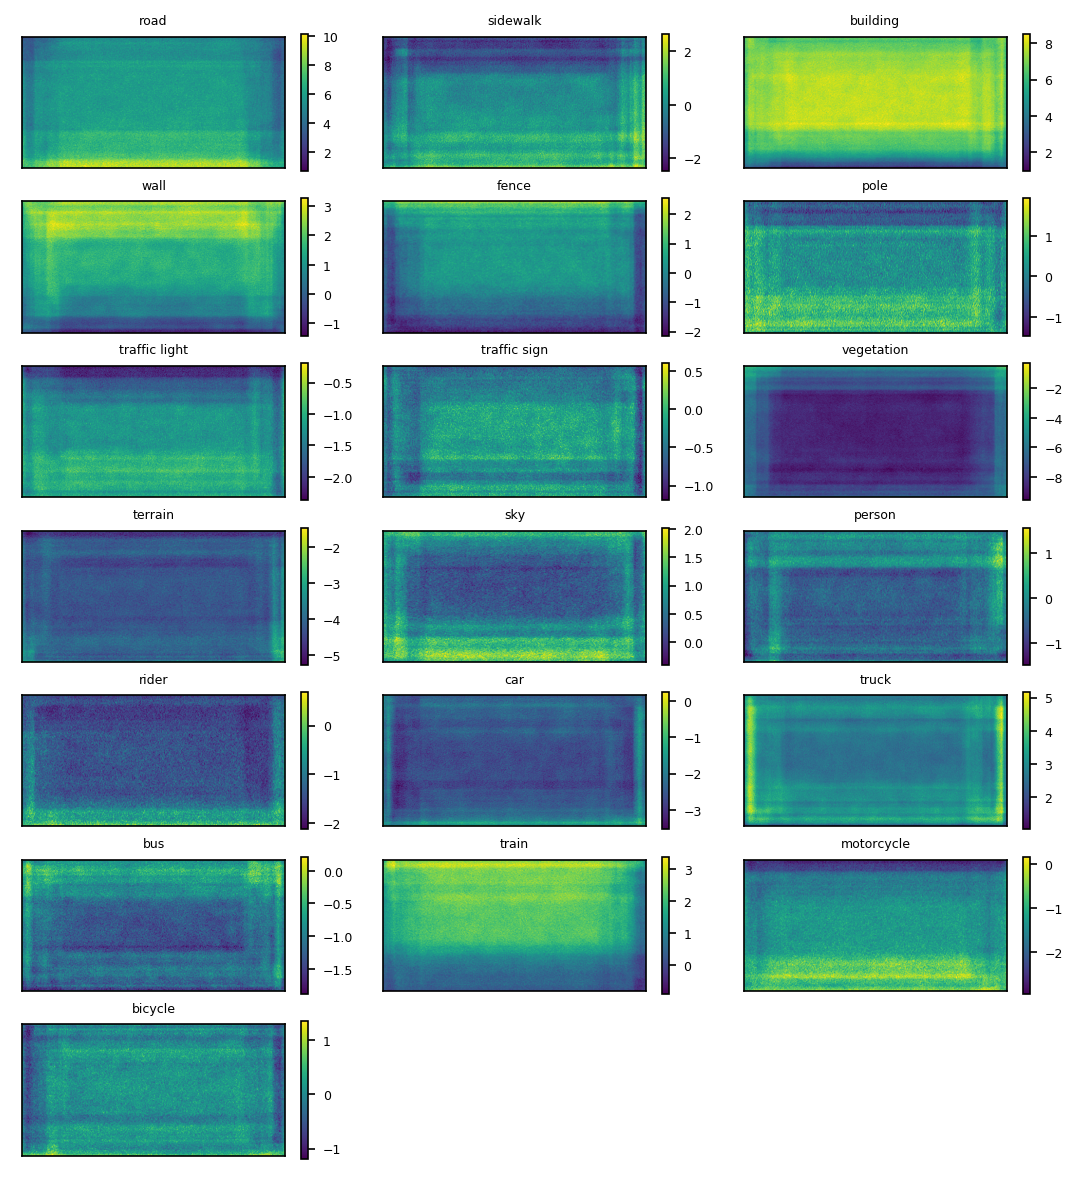

In [58]:
fig = plt.figure(figsize=(7, 10), dpi=150)
# fig.suptitle("classifier out map per class", fontsize=12)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)

mean_outp = torch.mean(outp, axis=0).detach().numpy()

for ind in range(19):
    ax = fig.add_subplot(7, 3, ind + 1)
    ax.set_title("{}".format(ind_to_label[ind]), fontsize=6)
    plt.imshow(mean_outp[ind])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=6) 
    ax.grid(b=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)




## Average Feature Map per Layer for Random Input Input

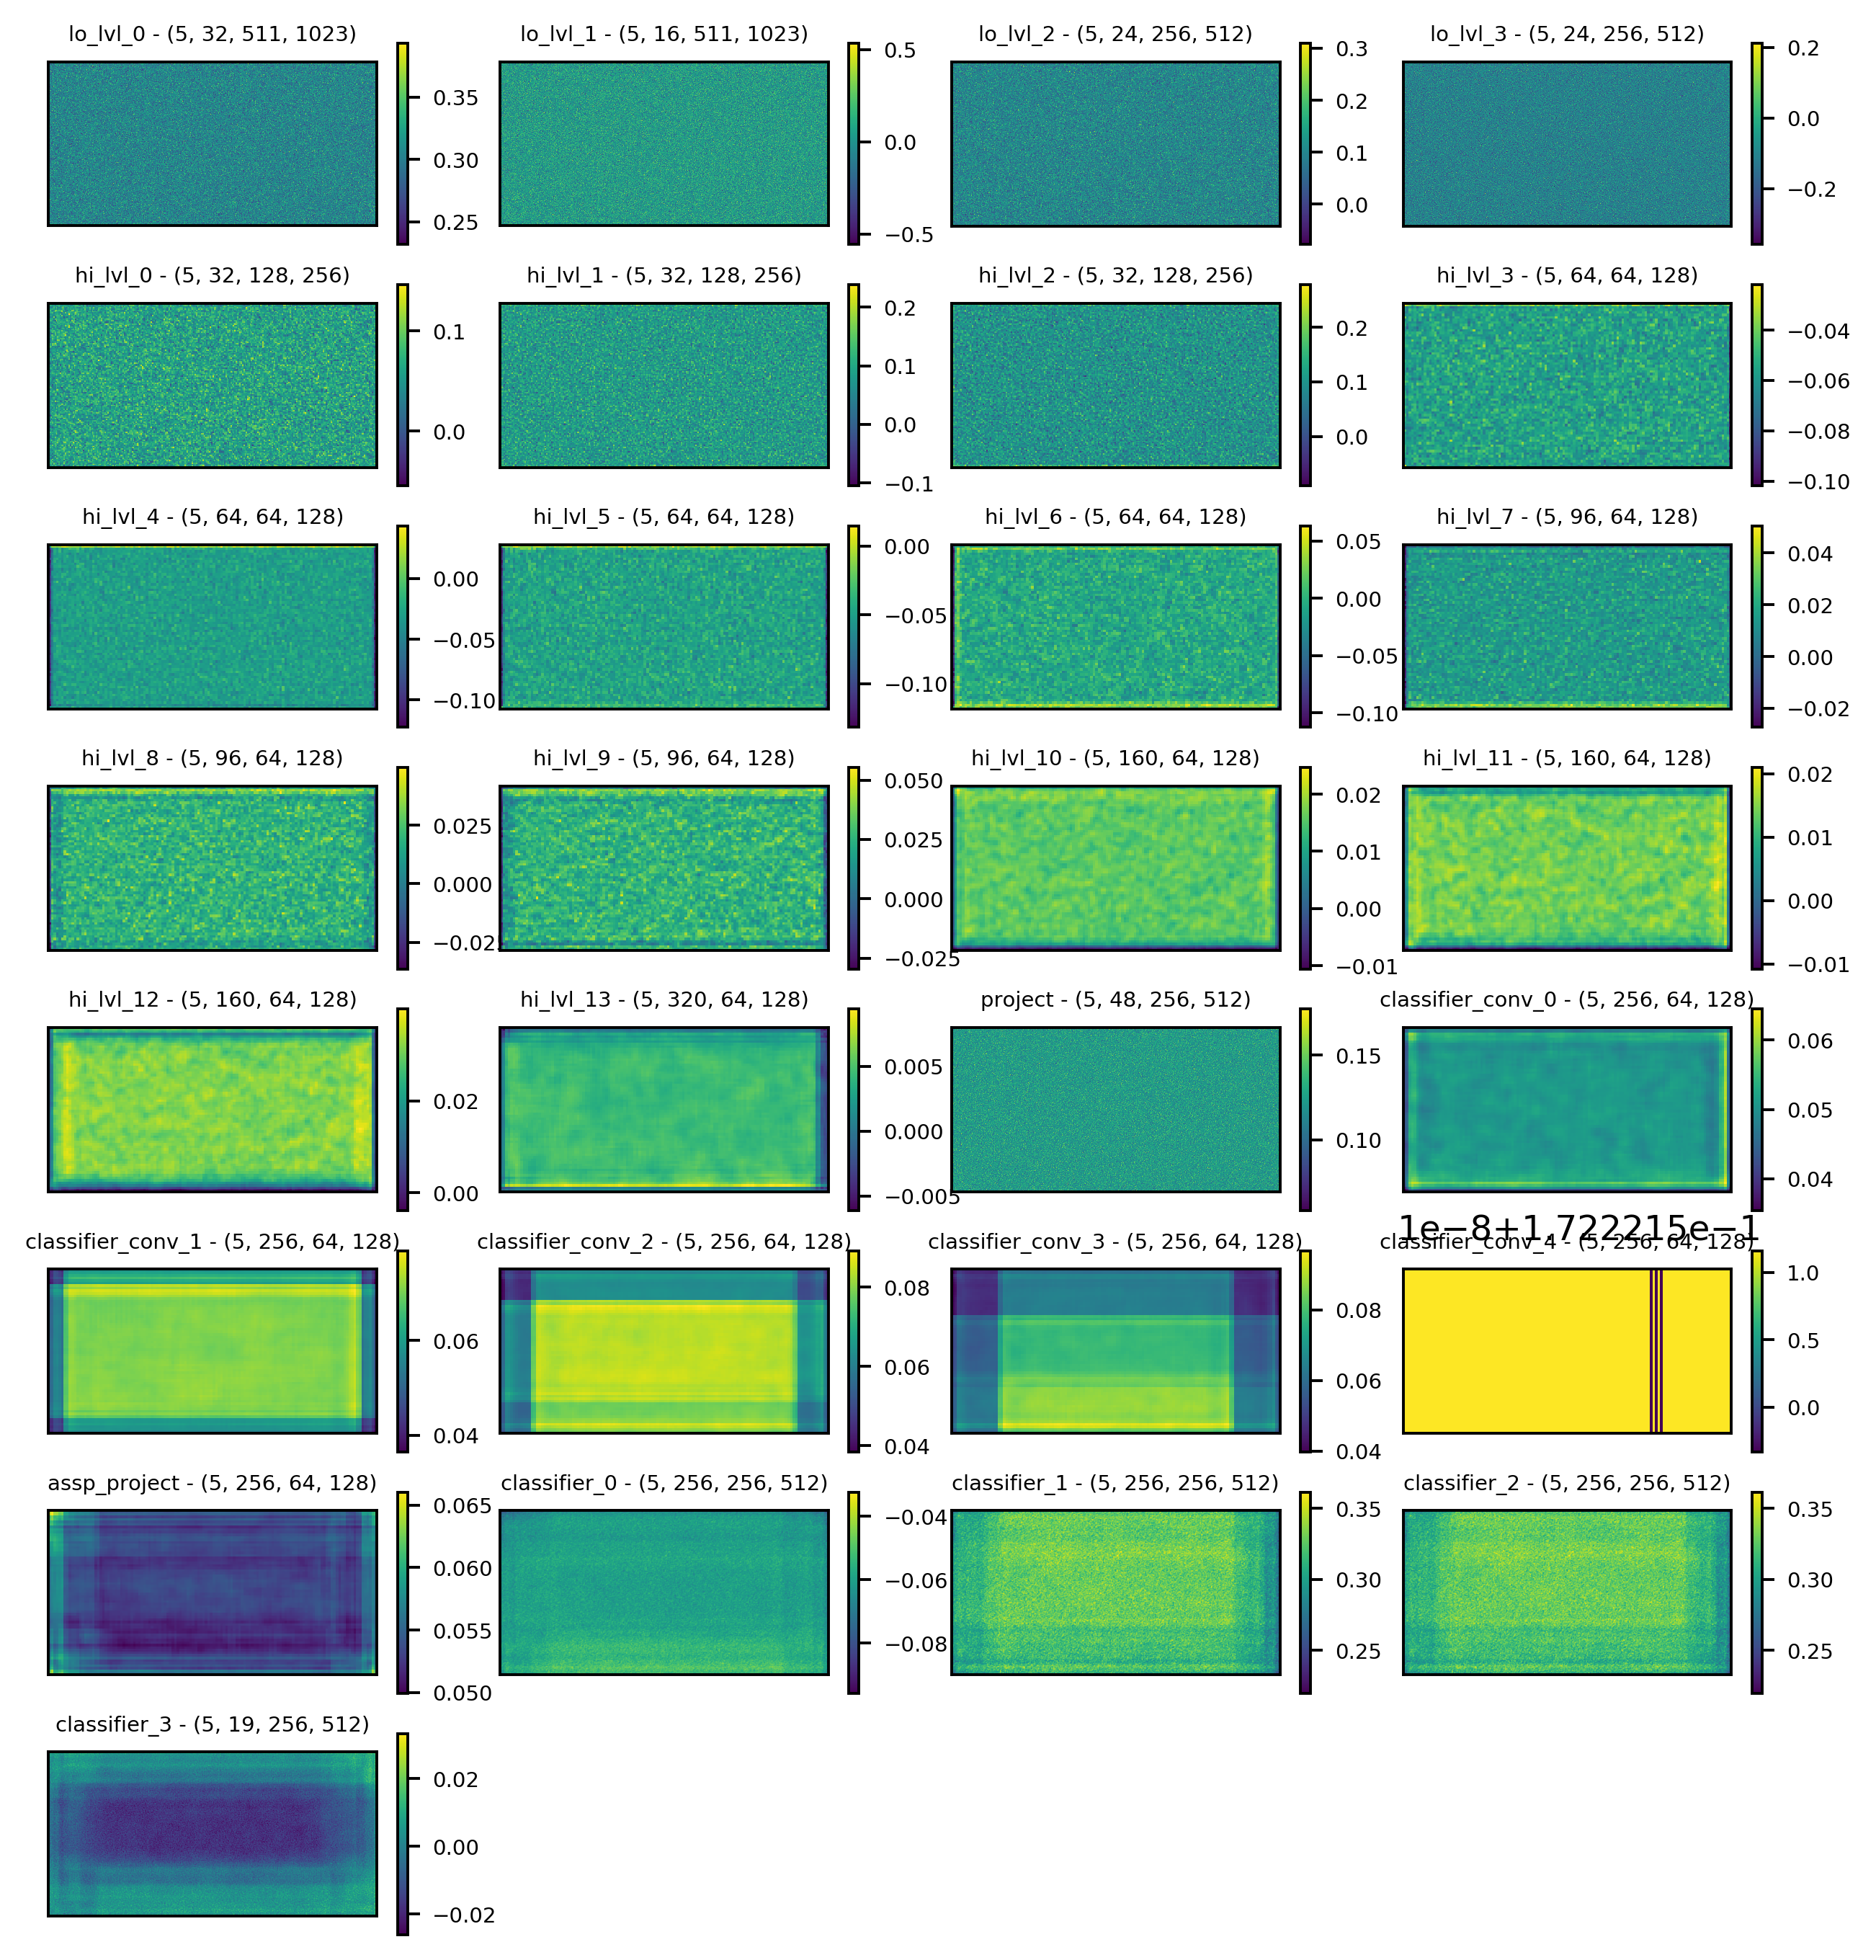

In [56]:
fig = plt.figure(figsize=(7, 10), dpi=350)

plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)

ind = 0
for key in activations.keys():
    ax = fig.add_subplot(8, 4, ind + 1)
    arr = np.array(activations[key])
    ax.set_title("{} - {}".format(key,arr.shape), fontsize=6)
    if len(arr.shape) > 3:
        arr = arr.mean(axis = (0, 1))
    if len(arr.shape) > 2:
        arr = arr.mean(axis = (0))
    plt.imshow(arr)
    cbar= plt.colorbar()
    cbar.ax.tick_params(labelsize=6) 

    ax.grid(b=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ind += 1



Notice how the feature maps in the upsampling layers (titled classifier_xx) start to develop strong artifacts. ON layer in particular, has very abnormal pattern. Let us examine the individual feature maps in this layer.

## Individual Feature Maps at DeepLab's ASPPPooling Layer

In [35]:
activations["classifier_conv_4"].shape

(1, 256, 64, 128)

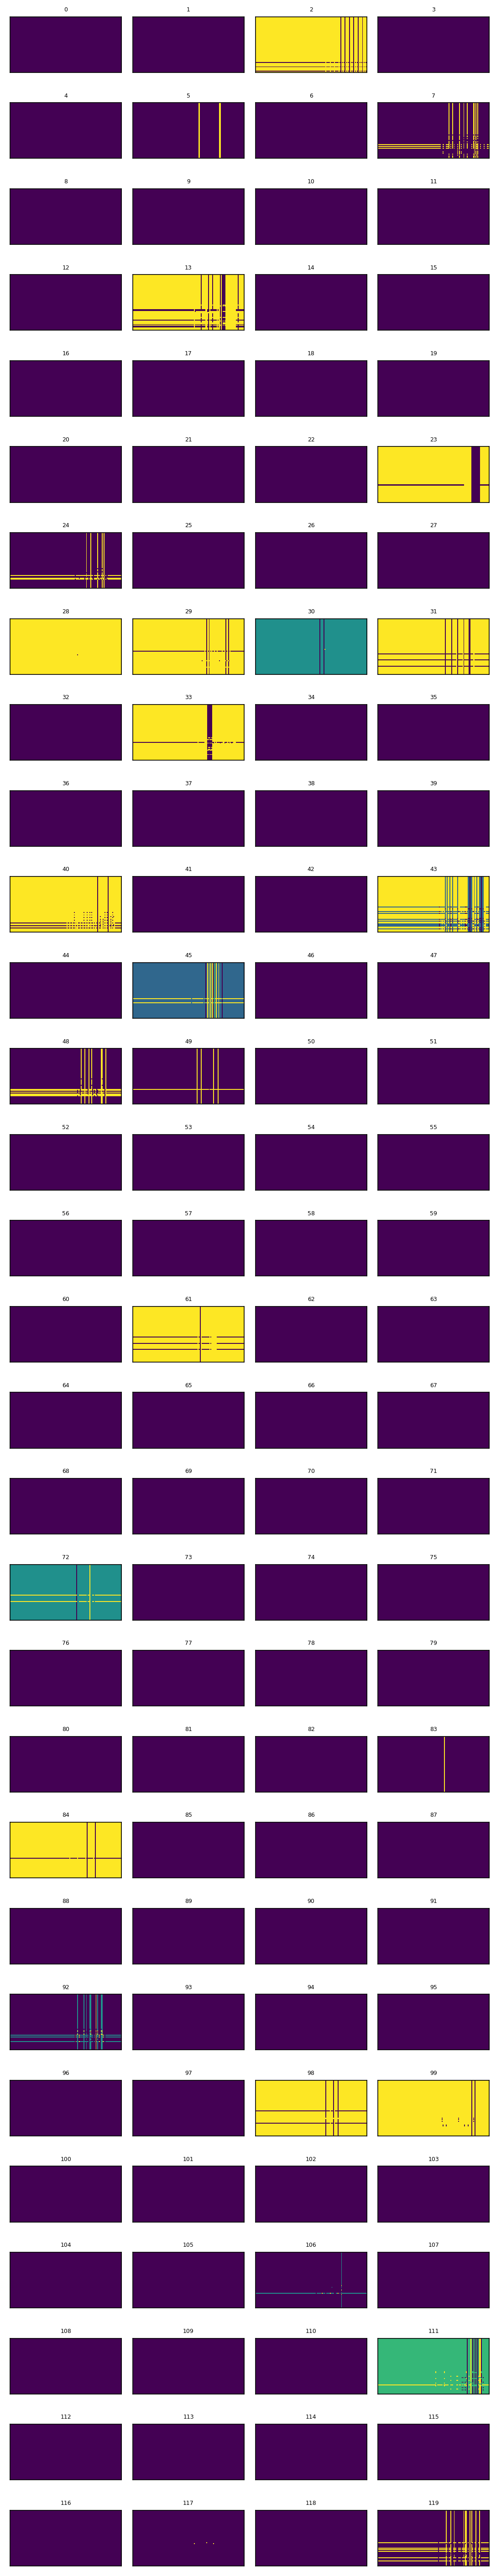

In [63]:
acts4 = np.mean(activations["classifier_conv_4"], axis = 0)

fig = plt.figure(figsize=(7, 50), dpi=150)

plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)


for ind in range(120):
    ax = fig.add_subplot(30, 4, ind + 1)
    ax.set_title("{}".format(ind), fontsize=6)
    plt.imshow(acts4[ind])
#    plt.colorbar()
    ax.grid(b=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



These individual maps show how border artifacts migrate to the interior of feature maps due to aggressive dilation factors of 6, 12, and 18 in the ASPP layers.

## Average Kernels

In [27]:
weight_mats = {}
for name, mod in model.named_modules():
    if hasattr(mod, "weight"):
        weight_mat = mod.weight.detach().numpy()
        if (len(weight_mat.shape)) == 4:
            # print("{} - {} - {}".format(weight_mat.shape, name, type(mod)))
            weight_mats[name] = np.sum(weight_mat, (0, 1))


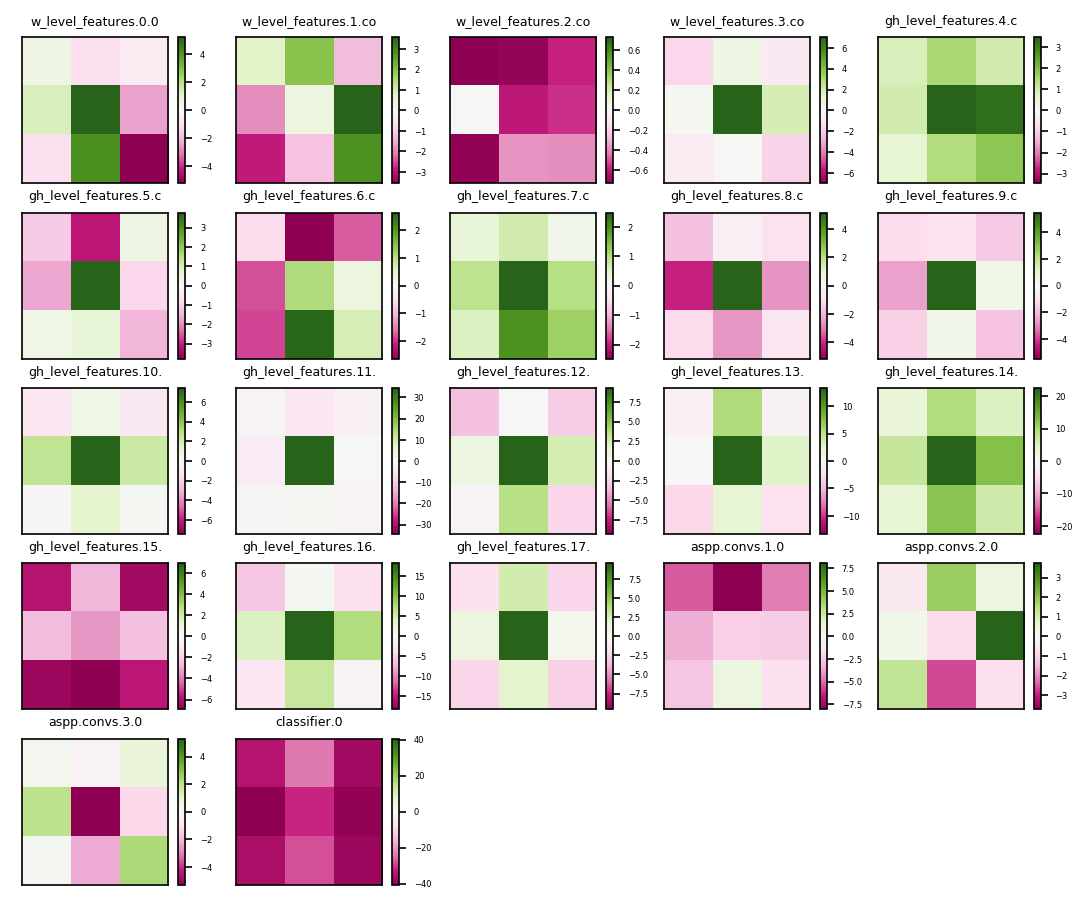

In [89]:
fig = plt.figure(figsize=(7, 20), dpi=150)
# fig.suptitle("classifier out map per class", fontsize=12)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)
ind = 0
for key in weight_mats:
    if len(weight_mats[key])== 1:
        continue
    ax = fig.add_subplot(len(weight_mats) / 5 + 1, 5, ind + 1)
    ax.set_title("{}".format(key[11:32]), fontsize=6)
    
    vmin = np.min(weight_mats[key])
    vmax = np.max(weight_mats[key])
    max_abs = max(np.abs(vmin), np.abs(vmax))

    plt.imshow(weight_mats[key], vmin=-max_abs, vmax =max_abs, cmap=plt.get_cmap('PiYG'))
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=4) 
    ax.grid(b=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ind += 1

